**PyPSA testing environment PL**


In [1]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt

print(f"PyPSA version: {pypsa.__version__}")
print("✓ Ready to build!")

PyPSA version: 0.32.1
✓ Ready to build!


In [2]:
### Exercise 2: Add Multiple Time Periods
#```python
# Create a new network with 168 hours (7 days)
network2 = pypsa.Network()
network2.set_snapshots(pd.date_range('2025-01-01', periods=24*7, freq='h'))

# Add components (same as before)
network2.add("Bus", "electricity_bus", carrier="AC")
network2.add("Generator", "hard_coal", bus="electricity_bus",
             p_nom=21_000, marginal_cost=130, p_min_pu=0.25, carrier = "AC")

network2.add("Generator", "lignite", bus="electricity_bus",carrier = "AC",
             p_nom=9_000, marginal_cost=120)

network2.add("Generator", "gas", bus="electricity_bus",carrier = "AC",
             p_nom=6_000, marginal_cost=110)

network2.add("Generator", "oil", bus="electricity_bus",carrier = "AC",
             p_nom=700, marginal_cost=300)

network2.add("Generator", "biomass", bus="electricity_bus",carrier = "AC",
             p_nom=1_300, marginal_cost=100)

network2.add("Generator", "hydro", bus="electricity_bus",carrier = "AC",
             p_nom=1_000, marginal_cost=0)

# Add wind farm with hourly availability
network2.add("Generator", "wind_farm",bus="electricity_bus", carrier = "AC",
    p_nom=11_000,  marginal_cost=0)

# Add solar generation
network2.add("Generator",    "solar_ground",    bus="electricity_bus",
    p_nom=12_000,     marginal_cost=0,     carrier="AC")

network2.add("Generator",    "solar_roof",    bus="electricity_bus",
    p_nom=13_000,    marginal_cost=0, p_min_pu=0.0,  carrier="AC")

# Add a battery to store excess generation
network2.add(    "StorageUnit",     "battery",     bus="electricity_bus",
    p_nom=1_000,              # 250_000 MW charge/discharge power
    max_hours=3,            # 1_000_000 MWh energy capacity (200 MW × 4h)
    efficiency_store=0.95,  # 95% efficient charging
    efficiency_dispatch=0.95,  # 95% efficient discharging
    marginal_cost=2)         # Small cost for battery use

# Add pumped hydro storage (larger, slower)
network2.add(    "StorageUnit",     "pumped_hydro",     bus="electricity_bus",
    p_nom=1_800,        # 1,000,000 MW charge/discharge power
    max_hours=8,            # 8,000,000 MWh energy capacity
    efficiency_store=0.9,     efficiency_dispatch=0.9,     marginal_cost=1)

    #wind profile a % of nominal power at ach interval (hour)
wind_profile = [
    0.05, 0.12, 0.20, 0.25, 0.30, 0.35,
    0.45, 0.55, 0.60, 0.58, 0.52, 0.45,
    0.35, 0.30, 0.28, 0.32, 0.40, 0.50,
    0.65, 0.70, 0.62, 0.50, 0.50, 0.40,
]

wind_profile = wind_profile * 7

# Simple solar availability profile (0-1)
solar_profile = [
    0.00, 0.00, 0.00, 0.00, 0.00, 0.05,
    0.15, 0.30, 0.50, 0.70, 0.85, 0.95,
    1.00, 0.95, 0.85, 0.70, 0.50, 0.30,
    0.15, 0.05, 0.00, 0.00, 0.00, 0.00,
]

solar_profile = solar_profile * 7

#this scales max permissible power to profile series above
network2.generators_t.p_max_pu["wind_farm"] = pd.Series(
    wind_profile, index=network2.snapshots
)

network2.generators_t.p_max_pu["solar_ground"] = pd.Series(
    solar_profile, index=network2.snapshots
)

network2.generators_t.p_max_pu["solar_roof"] = pd.Series(
    solar_profile, index=network2.snapshots
)

# Add time-varying demand
# Add time-varying demand (7 separate daily profiles, MWh per hour)
# Add time-varying demand (7 separate daily profiles, MWh per hour)
day1 = [15188.25, 14975, 15141.5, 15607.25, 17159.75, 20480.5, 22128.5, 23128,
        23168, 22458.5, 22715, 22966.25, 22869.25, 23060, 22883.5, 23202.75,
        23654.25, 23442.5, 23439.5, 22791.25, 21235.25, 19829.75, 18459.25, 15572]
day2 = [12786, 12723, 12714.5, 12387, 12930.5, 14131.75, 14925.75, 15472.25,
        15664.25, 15839.5, 15378.75, 15046.25, 14903, 14610.75, 15071.75, 15410,
        15792.5, 15879.75, 16343.5, 15602, 14673.75, 13387, 13938, 13251.75]
day3 = [14531.5, 14596.5, 14746.75, 15498.5, 17776.75, 19109.75, 19214.75, 19074.25,
        18768.25, 19096.25, 19238, 19365, 19211.5, 19531.75, 19477.5, 19618.5,
        19793.25, 20020, 19634.5, 18654.5, 17280, 15930.5, 15537, 14943.25]
day4 = [12228.5, 12031.5, 11687.25, 11492.75, 11898.25, 12693, 13435.5, 13894.5,
        14747.75, 14703.25, 15139.75, 15500.25, 15040, 14423.75, 14926.5, 15072.25,
        15377, 15853, 15927, 15937.75, 15227, 14242.75, 13219, 12636]
day5 = [14132.25, 14135.5, 14303, 14804.75, 16875.5, 18272.25, 18639.75, 18229.5,
        18217.5, 18342.75, 18586, 18410.25, 18642.25, 19204, 19284.75, 19680.25,
        19817.25, 20022, 20368.5, 18928.25, 17257.25, 15935, 15030.25, 14457.75]
day6 = [15193.75, 15194, 15566.5, 16550.5, 19358.75, 20742.5, 21269, 21065,
        20699.75, 20761.25, 21150.25, 20852.75, 20885.75, 20910.5, 21130, 21279,
        21902, 22119, 21470.5, 19966.75, 18287, 16974.5, 16005.75, 15470.75]
day7 = [17152.25, 16918.25, 17091.5, 17478.25, 18633.25, 21636.75, 23196, 24094.25,
        24441.25, 24403, 24650, 24873.25, 24791.75, 24523, 24621, 24781.75,
        24477.5, 24135, 23991.75, 23301.75, 21645.75, 20198, 18752.75, 17716.75]

demand_profile = day1 + day2 + day3 + day4 + day5 + day6 + day7
network2.add("Load", "demand", bus="electricity_bus",   p_set=demand_profile)


Index(['demand'], dtype='object')

In [3]:
### Exercise 3: Add Battery Storage




In [4]:
# Pre-check demand vs available supply
load = network2.loads_t.p_set.sum(axis=1)

daily_load = load.resample("D").sum()
print("Total load per day (MWh):")
print(daily_load)


print("Max installed generation (MW):", network2.generators.p_nom.sum())


print("Max installed generation+storage (MW):", network2.generators.p_nom.sum() + network2.storage_units.p_nom.sum())

# Per-hour max available generation (uses p_max_pu when provided)
p_max_pu = network2.generators_t.p_max_pu.reindex(
    index=network2.snapshots,
    columns=network2.generators.index,
).fillna(1.0)
max_gen = p_max_pu.mul(network2.generators.p_nom, axis=1).sum(axis=1)

# Optional storage discharge headroom (power-only)
max_storage = network2.storage_units.p_nom.sum() if not network2.storage_units.empty else 0
max_supply = max_gen + max_storage

shortage = load - max_supply
print("Worst shortage (MW):", shortage.max())
print("Hours with shortage:", (shortage > 0).sum())

# Minimum generation vs load check (p_min_pu)
min_gen = (network2.generators.p_nom * network2.generators.p_min_pu.fillna(0)).sum()
oversupply = min_gen - load
print("Worst oversupply from mins (MW):", oversupply.max())
print("Hours oversupplied:", (oversupply > 0).sum())

# Show the worst 5 shortage hours for quick diagnosis
if (shortage > 0).any():
    print()
    print("Top shortage hours (MW):")
    print(shortage[shortage > 0].sort_values(ascending=False).head(5))


Total load per day (MWh):
snapshot
2025-01-01    495555.75
2025-01-02    348863.25
2025-01-03    430648.50
2025-01-04    337334.25
2025-01-05    421576.50
2025-01-06    464805.50
2025-01-07    527504.75
Freq: D, dtype: float64
Max installed generation (MW): 75000.0
Max installed generation+storage (MW): 77800.0
Worst shortage (MW): -25197.75
Hours with shortage: 0
Worst oversupply from mins (MW): -6242.75
Hours oversupplied: 0


In [5]:
# Pre-check demand vs available supply
load = network2.loads_t.p_set.sum(axis=1)

daily_load = load.resample("D").sum()
print("Total load per day (MWh):")
print(daily_load)


# Build per-snapshot availability (defaults to 1.0 if no p_max_pu set)
p_max_pu = network2.generators_t.p_max_pu.reindex(
    index=network2.snapshots,
    columns=network2.generators.index,
).fillna(1.0)

max_gen = p_max_pu.mul(network2.generators.p_nom, axis=1).sum(axis=1)

# Optional: allow storage to discharge (power limit only, ignores energy)
max_discharge = network2.storage_units.p_nom.sum() if not network2.storage_units.empty else 0
max_supply = max_gen + max_discharge

shortage = load - max_supply
print("Worst shortage (MW):", shortage.max())
print("Hours short:", (shortage > 0).sum())

# Check minimum generation vs load (+ battery charging capacity)
min_gen_total = (network2.generators.p_nom * network2.generators.p_min_pu.fillna(0)).sum()
max_charge = network2.storage_units.p_nom.sum() if not network2.storage_units.empty else 0
oversupply = min_gen_total - (load + max_charge)
print("Worst oversupply from mins (MW):", oversupply.max())
print("Hours oversupplied:", (oversupply > 0).sum())


Total load per day (MWh):
snapshot
2025-01-01    495555.75
2025-01-02    348863.25
2025-01-03    430648.50
2025-01-04    337334.25
2025-01-05    421576.50
2025-01-06    464805.50
2025-01-07    527504.75
Freq: D, dtype: float64
Worst shortage (MW): -25197.75
Hours short: 0
Worst oversupply from mins (MW): -9042.75
Hours oversupplied: 0


In [6]:
network2.optimize(solver_name='highs')

Index(['electricity_bus'], dtype='object', name='Bus')
Index(['hard_coal', 'lignite', 'gas', 'oil', 'biomass', 'hydro', 'wind_farm',
       'solar_ground', 'solar_roof'],
      dtype='object', name='Generator')
Index(['electricity_bus'], dtype='object', name='Bus')
Index(['hard_coal', 'lignite', 'gas', 'oil', 'biomass', 'hydro', 'wind_farm',
       'solar_ground', 'solar_roof'],
      dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2520 primals, 5544 duals
Objective: 1.58e+08
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUni

Running HiGHS 1.9.0 (git hash: fa40bdf): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-01, 1e+00]
  Cost   [1e+00, 3e+02]
  Bound  [0e+00, 0e+00]
  RHS    [6e+02, 2e+04]
Presolving model
504 rows, 2310 cols, 3316 nonzeros  0s
443 rows, 1588 cols, 2350 nonzeros  0s
Presolve : Reductions: rows 443(-5101); columns 1588(-932); elements 2350(-6216)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.1466022427e+08 Pr: 107(1.31082e+06) 0s
        515     1.5812972204e+08 Pr: 0(0); Du: 0(1.7053e-13) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-eqf4nnnc
Model status        : Optimal
Simplex   iterations: 515
Objective value     :  1.5812972204e+08
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.01
Writing the solution to /tmp/linopy-solve-wpuh7ien.sol


('ok', 'optimal')


Hourly load vs. generation (MW):
                      load_MW  hard_coal_MW  lignite_MW     gas_MW  oil_MW  biomass_MW  hydro_MW  solar_ground_MW  \
hour                                                                                                                
2025-01-01 00:00:00  15188.25        5250.0     1088.25  6000.0000    -0.0      1300.0    1000.0             -0.0   
2025-01-01 01:00:00  14975.00        5250.0      105.00  6000.0000    -0.0      1300.0    1000.0             -0.0   
2025-01-01 02:00:00  15141.50        5250.0       -0.00  5391.5000    -0.0      1300.0    1000.0             -0.0   
2025-01-01 03:00:00  15607.25        5250.0       -0.00  5307.2500    -0.0      1300.0    1000.0             -0.0   
2025-01-01 04:00:00  17159.75        5250.0      309.75  6000.0000    -0.0      1300.0    1000.0             -0.0   
...                       ...           ...         ...        ...     ...         ...       ...              ...   
2025-01-07 19:00:00  23301.75 

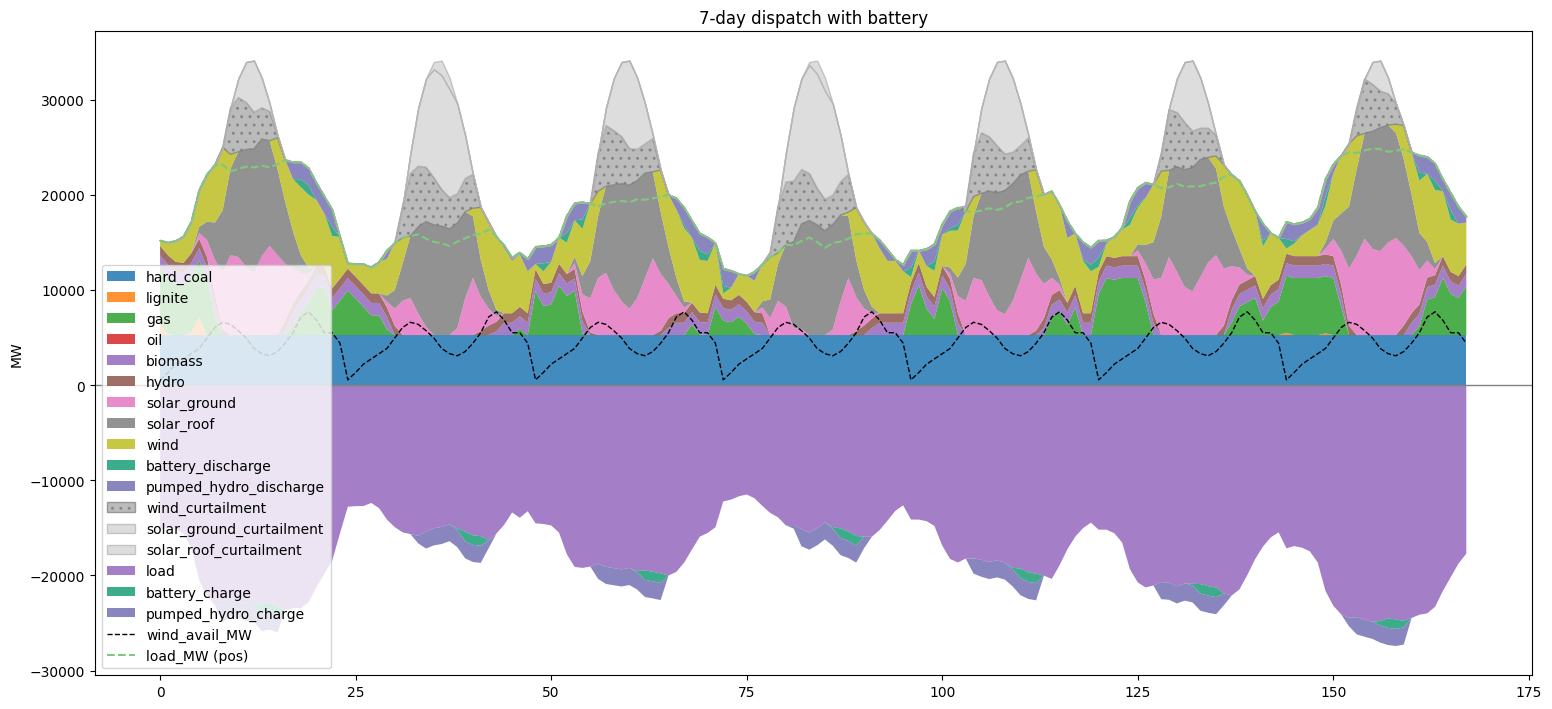


Installed power breakdown (MW):
name,type,p_nom_MW
              p_nom_MW       type
hard_coal      21000.0  generator
solar_roof     13000.0  generator
solar_ground   12000.0  generator
wind_farm      11000.0  generator
lignite         9000.0  generator
gas             6000.0  generator
biomass         1300.0  generator
hydro           1000.0  generator
oil              700.0  generator
pumped_hydro    1800.0    storage
battery         1000.0    storage
Total installed generation (MW): 75,000
Total installed storage power (MW): 2,800

Average curtailment (MW): 3,029.48
Total curtailment (MWh): 508,952.49

Solar curtailment (%% of available): 19.07%

Total load per day (MWh):
hour
2025-01-01    495555.75
2025-01-02    348863.25
2025-01-03    430648.50
2025-01-04    337334.25
2025-01-05    421576.50
2025-01-06    464805.50
2025-01-07    527504.75
Freq: D, Name: load_MW, dtype: float64

Curtailment by source:
              Delivered MWh  Curtailed MWh  % curtailed
Generator             

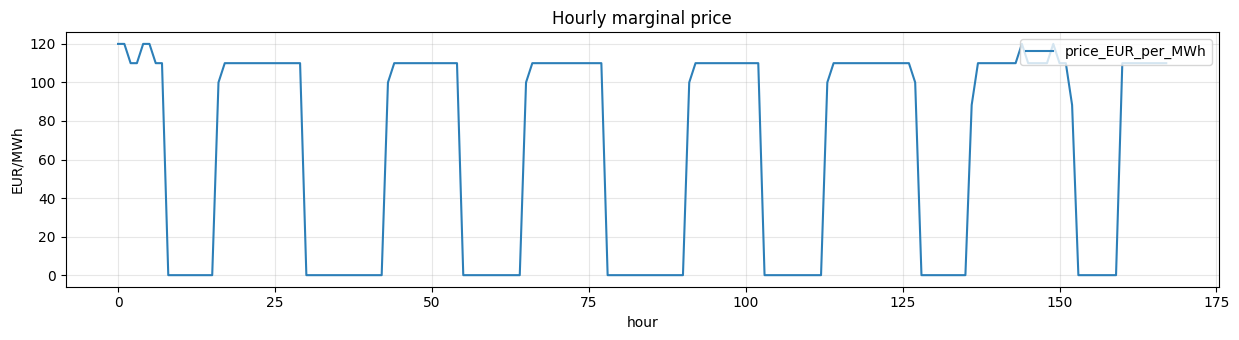

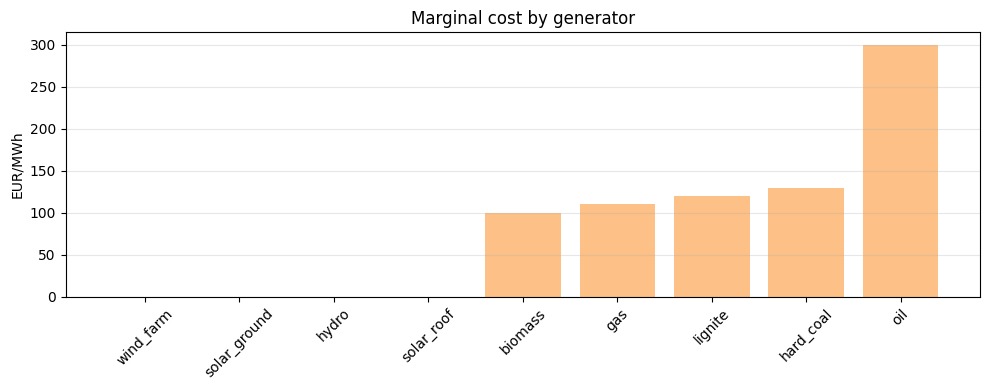

In [7]:
#see how dispatch varies!


# Show hourly load vs generation
wind_avail = (
    network2.generators_t.p_max_pu["wind_farm"]
    * network2.generators.at["wind_farm", "p_nom"]
)
solar_ground_avail = (
    network2.generators_t.p_max_pu["solar_ground"]
    * network2.generators.at["solar_ground", "p_nom"]
)
solar_roof_avail = (
    network2.generators_t.p_max_pu["solar_roof"]
    * network2.generators.at["solar_roof", "p_nom"]
)
wind_curtailment = (
    wind_avail - network2.generators_t.p["wind_farm"]
).clip(lower=0)
solar_ground_curtailment = (
    solar_ground_avail - network2.generators_t.p["solar_ground"]
).clip(lower=0)
solar_roof_curtailment = (
    solar_roof_avail - network2.generators_t.p["solar_roof"]
).clip(lower=0)
price = network2.buses_t.marginal_price["electricity_bus"]
hourly = pd.DataFrame({
    "load_MW": network2.loads_t.p_set["demand"],
    "hard_coal_MW": network2.generators_t.p["hard_coal"],
    "lignite_MW": network2.generators_t.p["lignite"],
    "gas_MW": network2.generators_t.p["gas"],
    "oil_MW": network2.generators_t.p["oil"],
    "biomass_MW": network2.generators_t.p["biomass"],
    "hydro_MW": network2.generators_t.p["hydro"],
    "solar_ground_MW": network2.generators_t.p["solar_ground"],
    "solar_roof_MW": network2.generators_t.p["solar_roof"],
    "wind_MW": network2.generators_t.p["wind_farm"],
    "wind_avail_MW": wind_avail,
    "wind_curtailment_MW": wind_curtailment,
    "solar_ground_curtailment_MW": solar_ground_curtailment,
    "solar_roof_curtailment_MW": solar_roof_curtailment,
    "price_EUR_per_MWh": price,
    "battery_MW": network2.storage_units_t.p["battery"],
    "pumped_hydro_MW": network2.storage_units_t.p["pumped_hydro"],
}, index=network2.snapshots)
hourly.index.name = "hour"

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

print("\nHourly load vs. generation (MW):")
print(hourly)

# Plot dispatch with battery and wind availability (stacked)
plot_df = hourly[[
    "hard_coal_MW", "lignite_MW", "gas_MW", "oil_MW",
    "biomass_MW", "hydro_MW", "solar_ground_MW", "solar_roof_MW",
    "wind_MW", "battery_MW", "pumped_hydro_MW", "wind_curtailment_MW", "solar_ground_curtailment_MW", "solar_roof_curtailment_MW", "load_MW", "wind_avail_MW"
]].copy()
plot_df.index = range(len(plot_df))

battery_discharge = plot_df["battery_MW"].clip(lower=0)
battery_charge = -plot_df["battery_MW"].clip(upper=0)

pumped_hydro_discharge = plot_df["pumped_hydro_MW"].clip(lower=0)
pumped_hydro_charge = -plot_df["pumped_hydro_MW"].clip(upper=0)

supply = pd.DataFrame({
    "hard_coal": plot_df["hard_coal_MW"],
    "lignite": plot_df["lignite_MW"],
    "gas": plot_df["gas_MW"],
    "oil": plot_df["oil_MW"],
    "biomass": plot_df["biomass_MW"],
    "hydro": plot_df["hydro_MW"],
    "solar_ground": plot_df["solar_ground_MW"],
    "solar_roof": plot_df["solar_roof_MW"],
    "wind": plot_df["wind_MW"],
    "battery_discharge": battery_discharge,
    "pumped_hydro_discharge": pumped_hydro_discharge,
    "wind_curtailment": plot_df["wind_curtailment_MW"],
    "solar_ground_curtailment": plot_df["solar_ground_curtailment_MW"],
    "solar_roof_curtailment": plot_df["solar_roof_curtailment_MW"],
})

demand = pd.DataFrame({
    "load": plot_df["load_MW"],
    "battery_charge": battery_charge,
    "pumped_hydro_charge": pumped_hydro_charge,
})

fig, ax = plt.subplots(figsize=(15.625, 7.2))
supply_polys = ax.stackplot(
    plot_df.index,
    supply.T.values,
    labels=supply.columns,
    alpha=0.85,
)

demand_polys = ax.stackplot(
    plot_df.index,
    -demand.T.values,
    labels=demand.columns,
    alpha=0.85,
)

supply_cols = list(supply.columns)
demand_cols = list(demand.columns)

battery_color = "#1b9e77"
pumped_color = "#7570b3"
wind_curt_color = "#9e9e9e"
solar_curt_color = "#cfcfcf"

# Match charge/discharge colors
supply_polys[supply_cols.index("battery_discharge")].set_facecolor(battery_color)
demand_polys[demand_cols.index("battery_charge")].set_facecolor(battery_color)
supply_polys[supply_cols.index("pumped_hydro_discharge")].set_facecolor(pumped_color)
demand_polys[demand_cols.index("pumped_hydro_charge")].set_facecolor(pumped_color)

# Curtailment styling
wind_idx = supply_cols.index("wind_curtailment")
supply_polys[wind_idx].set_facecolor(wind_curt_color)
supply_polys[wind_idx].set_edgecolor("#7a7a7a")
supply_polys[wind_idx].set_hatch("..")
supply_polys[wind_idx].set_alpha(0.7)
for name in ["solar_ground_curtailment", "solar_roof_curtailment"]:
    idx = supply_cols.index(name)
    supply_polys[idx].set_facecolor(solar_curt_color)
    supply_polys[idx].set_edgecolor("#b0b0b0")
    supply_polys[idx].set_alpha(0.7)
ax.plot(
    plot_df.index,
    plot_df["wind_avail_MW"],
    color="black",
    linestyle="--",
    linewidth=1,
    label="wind_avail_MW",
)

ax.plot(
    plot_df.index,
    plot_df["load_MW"],
    color="#7fc97f",
    linestyle="--",
    linewidth=1.5,
    label="load_MW (pos)",
)
ax.axhline(0, color="gray", linewidth=1)
ax.set_ylabel("MW")
ax.set_title("7-day dispatch with battery")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

installed_gen = network2.generators[["p_nom"]].rename(columns={"p_nom": "p_nom_MW"})
installed_gen["type"] = "generator"
installed_storage = network2.storage_units[["p_nom"]].rename(columns={"p_nom": "p_nom_MW"})
installed_storage["type"] = "storage"
installed = pd.concat([installed_gen, installed_storage]).sort_values(["type", "p_nom_MW"], ascending=[True, False])
print()
print("Installed power breakdown (MW):")
print("name,type,p_nom_MW")
print(installed)
print(f"Total installed generation (MW): {installed_gen['p_nom_MW'].sum():,.0f}")
print(f"Total installed storage power (MW): {installed_storage['p_nom_MW'].sum():,.0f}")

total_curtailment_series = hourly[[
    "wind_curtailment_MW",
    "solar_ground_curtailment_MW",
    "solar_roof_curtailment_MW",
]].sum(axis=1)
avg_curtailment = total_curtailment_series.mean()
total_curtailment = total_curtailment_series.sum()
print()
print(f"Average curtailment (MW): {avg_curtailment:,.2f}")
print(f"Total curtailment (MWh): {total_curtailment:,.2f}")

solar_delivered = (
    hourly["solar_ground_MW"] + hourly["solar_roof_MW"]
)
solar_curtailed = (
    hourly["solar_ground_curtailment_MW"]
    + hourly["solar_roof_curtailment_MW"]
)
solar_curt_pct = (
    solar_curtailed.sum() / (solar_delivered.sum() + solar_curtailed.sum()) * 100
).item()
print()
print(f"Solar curtailment (%% of available): {solar_curt_pct:,.2f}%")

daily_load = hourly["load_MW"].resample("D").sum()
print()
print("Total load per day (MWh):")
print(daily_load)

# Curtailment percentage by source (wind/solar)
curtail_sources = ["wind_farm", "solar_ground", "solar_roof"]
avail_by_source = network2.generators_t.p_max_pu[curtail_sources].multiply(
    network2.generators.loc[curtail_sources, "p_nom"], axis=1
)
delivered_by_source = network2.generators_t.p[curtail_sources]
curtailed_by_source = (avail_by_source - delivered_by_source).clip(lower=0)
total_delivered = delivered_by_source.sum()
total_curtailed = curtailed_by_source.sum()
curtailment_pct = (
    total_curtailed / (total_delivered + total_curtailed) * 100
).fillna(0)
curtailment_summary = pd.DataFrame({
    "Delivered MWh": total_delivered,
    "Curtailed MWh": total_curtailed,
    "% curtailed": curtailment_pct,
})
curtailment_summary.index.name = "Generator"
print()
print("Curtailment by source:")
print(curtailment_summary.to_string())

fig, ax = plt.subplots(figsize=(12.5, 3.5))
ax.plot(
    plot_df.index,
    hourly["price_EUR_per_MWh"].values,
    color="#2c7fb8",
    linewidth=1.5,
    label="price_EUR_per_MWh",
)
ax.set_ylabel("EUR/MWh")
ax.set_xlabel("hour")
ax.set_title("Hourly marginal price")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Marginal cost by carrier (or generator name if carrier is not informative)
gen_costs = network2.generators[["marginal_cost"]].copy()
if "carrier" in network2.generators.columns and network2.generators["carrier"].nunique() > 1:
    gen_costs["carrier"] = network2.generators["carrier"]
    cost_summary = gen_costs.groupby("carrier")["marginal_cost"].mean().sort_values()
    cost_label = "carrier"
else:
    cost_summary = network2.generators["marginal_cost"].sort_values()
    cost_label = "generator"

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(cost_summary.index, cost_summary.values, color="#fdc086")
ax.set_ylabel("EUR/MWh")
ax.set_title(f"Marginal cost by {cost_label}")
ax.grid(axis="y", alpha=0.3)
ax.tick_params(axis="x", labelrotation=45)
plt.tight_layout()
plt.show()


## 📚 Resources

- **PyPSA Documentation**: https://pypsa.readthedocs.io/
- **Component Reference**: https://pypsa.readthedocs.io/en/latest/components.html
- **Examples**: https://pypsa.readthedocs.io/en/latest/examples-basic.html

---

## 🎉 Congratulations!

You've built a PyPSA model from scratch! You now understand:
- ✅ How to create networks, buses, generators, and loads
- ✅ What optimization does and how to interpret results
- ✅ The relationship between capacity, dispatch, cost, and price

Now you're ready to build more complex models! 🚀